In [12]:
import numpy as np
import quantum_stuff as qs
from scipy.linalg import expm
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error as MSE
import sklearn.linear_model as LM
import matplotlib.pyplot as plt
from tqdm import tqdm
import scienceplots

plt.style.use(['science', 'no-latex'])

sx = qs.sigmax()
sy = qs.sigmay()
sz = qs.sigmaz()
I = np.eye(2)

In [13]:
def encoding(uk):
    op = np.einsum('i, jk -> ijk', (1-2*uk), qs.sigmaz())
    return 0.5*(I+op)

In [14]:
#Fixed Variables

Nq = 5
Nr = 5
Js = 1
δt = 10/Js
dim = 1000
wo = 1000
n = 1
train_size = 2000
test_size = 2000
uk = np.random.random(size = dim)
# res = [qs.zero(dm = True, N = Nq-1), qs.one(dm = True, N = Nq-1), qs.right(dm = True, N = Nq-1), qs.plus(dm = True, N = Nq-1), qs.left(dm = True, N = Nq-1)]
res = [qs.random_qubit(Nq-1, dm = True) for i in range(Nr)]

In [15]:
Δ = 1
# Δ2 = np.array([0,1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100])
Δ2 = 1
W = Δ2*Js
J = np.array([[qs.random_coupling(Js, Nq) for j in range(Nr)] for i in range(n)])
D = np.random.uniform(-W, W, size = (n, Nr, Nq))
h = Δ*Js

In [16]:
ρ = encoding(uk)

In [17]:
Z = qs.local_operators(sz, Nq)
X = qs.local_operators(sx, Nq)

In [18]:
H = [[qs.interaction(X, J[i][j]) + np.dot((h + D[i][j]),np.transpose(Z, (1, 0, 2))) for j in range(Nr)] for i in range(n)]

In [13]:
tstep = 1
distance = np.zeros((n, dim,Nr,Nr), dtype = complex)
mse_population = np.zeros((n, dim, Nr, Nr), dtype = complex)
for i in tqdm(range(n)):
    outputs_traced = np.zeros((Nr, dim, 2**(Nq-1), 2**(Nq-1)), dtype = complex)
    for j in range(Nr):
        outputs = qs.collisions(ρ, res[j], H[i][j], δt, tstep)
        outputs_traced[j] = qs.ptrace(outputs, [k for k in range(1,Nq)])
    for j in range(Nr):
        for k in range(Nr):
            distance[i,:,j,k] = (qs.fidelity(outputs_traced[j], outputs_traced[k]))
            mse_population[i,:,j,k] = np.sqrt(np.mean((np.diagonal(outputs_traced[j], axis1 = 1, axis2 = 2) - np.diagonal(outputs_traced[k], axis1 = 1, axis2 = 2))**2, axis = -1))


100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


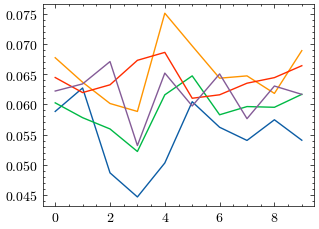

In [42]:
plt.plot(range(10), np.diagonal(outputs_traced, axis1=2, axis2=3)[:,990:,3].T)

c:\Users\marco\Desktop\Università\PhD\quantum_env\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
c:\Users\marco\Desktop\Università\PhD\quantum_env\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part


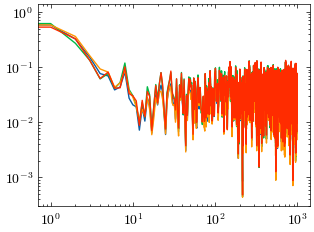

In [15]:
plt.loglog(range(dim), 1-distance[0,:,0,1:])

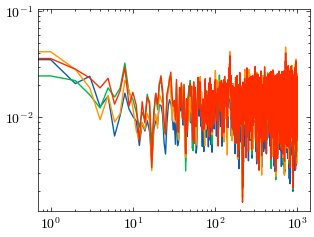

In [11]:
plt.loglog(range(dim), np.real(mse_population[0,:,0,1:]))

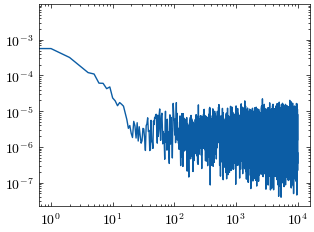

In [24]:
#Ensemble average with h = 10 on 100 hamiltonians, mse between the populations of 5 reservoirs starting from different initial conditions

plt.loglog(range(dim), np.real(mse))

In [60]:
y[4,0,:,0]

array([0.18985298+0.00000000e+00j, 0.15238839-3.59978098e-18j,
       0.13574206+6.72424144e-18j, ..., 0.0579378 +8.27429556e-18j,
       0.0455331 +1.23582528e-17j, 0.04459995+1.40735770e-17j])

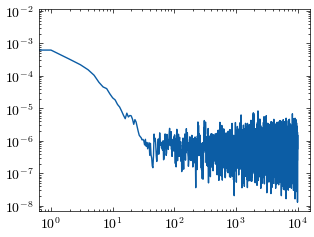

In [44]:
#Ensemble average with h = 10 on 300 hamiltonians, mse between the populations of 5 reservoirs starting from different initial conditions

plt.loglog(range(dim), np.real(mse))

Text(0, 0.5, 'Variance (Moving Window)')

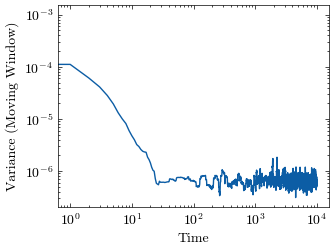

In [42]:
N = 31  # window size
moving_var = np.array([np.std(np.real(mse)[i:i+N]) for i in range(len(mse)-N+1)])

plt.figure()
plt.loglog(range(len(moving_var)), moving_var)
plt.xlabel('Time')

plt.ylabel('Variance (Moving Window)')

In [63]:
moving_var

array([1.38558788e-07, 4.20808937e-10, 1.19717403e-10, ...,
       2.01753027e-12, 1.97271209e-12, 1.99852105e-12])

ValueError: x and y must have same first dimension, but have shapes (10000,) and (1,)

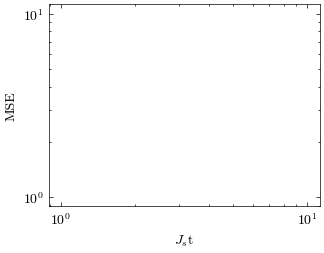

In [31]:
plt.figure()
plt.ylabel('MSE')
plt.xlabel('$J_s$t')

for k in range(m):
    plt.loglog(range(dim), mse[k])

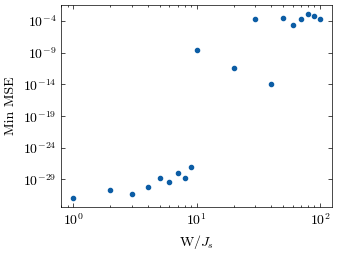

In [47]:
plt.figure()
plt.ylabel('Min MSE')
plt.xlabel('W/$J_s$')
plt.loglog(Δ2, np.min(mse, axis = 1), '.')

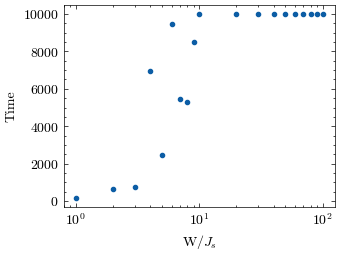

In [48]:
time = np.where(mse == np.min(mse, axis = 1)[:, np.newaxis])[1]
plt.figure()
plt.ylabel('Time')
plt.xlabel('W/$J_s$')
plt.semilogx(Δ2, time, '.')

In [41]:
time

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 array([ 550,  190,  632,  733, 6961, 2483, 9442, 5461, 5313, 8501, 9985,
        9998, 9971, 9998, 9985, 9997, 9986, 9993, 9987, 9987]))

Observations:
- With hamiltonians having different drivings/different J the synchronisation doesn't occurr